In [1]:
# Problnem statement 
# Input : text data from sentiment 140 dataset 
# Output : sentiment classification

# Import necessrary libraries.
# utilities
import re # Regular expression match, search, findall
import numpy as np 
import pandas as pd
import os

# Plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

# NLTK
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Importing the dataset.
location = r"C:\Users\every\OneDrive\NLP_project\Sentiment_analysis\archive\training.1600000.processed.noemoticon.csv"
dataset_columns = ['target','ids','date','flag','user','text'] # This will be the head of the columns
dataframe = pd.read_csv(location,names = dataset_columns, encoding='ISO-8859-1') # Names = columns

#dataframe = pd.concat([dataframe_positive,dataframe_negative]) # The command concatenate will connect two different dataframes.
#print(dataframe)
#print(dataframe.head()) # This is going to show us the first five rows of the dataframe.
#print(dataframe.columns)
#print(dataframe.info())
#print(np.sum(dataframe.isnull().any(axis=1))) # this is counting the missing value numbers for all columns. axis = 1 means column
#print(dataframe['target'].unique(), dataframe['target'].nunique()) # This will present how many unique values are in the column. 

# There are only 0 and 4.

C:\Users\every\AppData\Local\Temp\ipykernel_15700\1031097930.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1) # Currently, positive sentiment was labeled as 4, but we will replace it as 1 so that it is more intuitive.


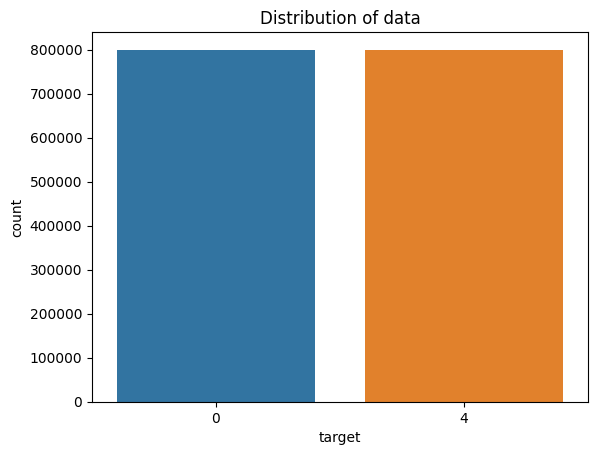

In [3]:
# Plotting the distribution for dataset. 
ax = dataframe.groupby('target').count().plot(kind='bar',title = 'Distribution of data',legend=False) # whole dataframe is grouped by target, which is the label.
ax.set_xticklabels(['Negative','Positive'],rotation = 0)
text, sentiment = list(dataframe['text']), list(dataframe['target'])
sns.countplot(x='target',data = dataframe)
#plt.show()

# then, we can start the pre-processing of the dataset.
data = dataframe[['text','target']] # We will select the text and the target column from the whole dataset. 
data['target'] = data['target'].replace(4,1) # Currently, positive sentiment was labeled as 4, but we will replace it as 1 so that it is more intuitive. 
#print(data['target'].unique()) # Check whether the replacement was done properly.

data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)] # Selecting specific columns and rows from the dataframe.
dataset = pd.concat([data_pos,data_neg])

# Convert uppercase into the lowercase.
dataset['text'] = dataset['text'].str.lower()
#print(dataset['text'].tail())


In [4]:
# Next, we define the stopwords list in English.
import spacy
import nltk
from spacy.lang.en.stop_words import STOP_WORDS 
# This module removes redundant words from the text.
stopwords = list(STOP_WORDS) # We can add or substract some of the words. 

def cleaning_stopwords(text) :
    return " ".join([word for word in str(text).split() if word not in stopwords])
    # This function will return the survived words from the input. 
dataset['text'] = dataset['text'].apply(lambda text : cleaning_stopwords(text)) # This line means that for all the elements in dataset[txt], the function will be applied.
#print(dataset['text'].head())

In [5]:
# Cleaning and removing punctuations.
import string 
english_punctuations = string.punctuation
punctuation_list = english_punctuations

def cleaning_punctuations(text) :
    translator = str.maketrans('','',punctuation_list) # str is a converting function, like 'int' function.
    # Syntax of maketrans function is str.maketrans(x,y,z)
    # Where x is the original string. 
    # y is a string with same length of x. 
    # x[i] will be replaced to y[i].
    # z is an optional input, this is a string describing which characters to remove from the original string.
    # therefore, this function makes sense. x and y parameter have the same length and z is something that we should remove.
    return text.translate(translator)
dataset['text'] = dataset['text'].apply(lambda text: cleaning_punctuations(text))
#print(dataset['text'].tail())


In [6]:
# Cleaning and removing repeating characters. 
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+',r'1',text) # re.sub() function replaces certain string with another string.
# I think the second parameter should be '', not '1'?
    # Syntax : re.sub(x,y,z)
    # x is the string that should be replaced. 
    # y is the string that will substitute x. 
    # z is a set of strings. In this case it will be a sentence or a paragraph.
dataset['text'] = dataset['text'].apply(lambda text: cleaning_repeating_char(text))
#print(dataset['text'].tail()) 


In [7]:
# Cleaning and removing URLs.
def cleaning_URLs(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text) 
    # Caveat : | means 'OR' ( \ does not work.)
    # This function will remove the letters whenever it encounters 'www' OR 'https:/'
dataset['text'] = dataset['text'].apply(lambda text : cleaning_URLs(text))
# Apply this function for every element in the 'text' column
#print(dataset['text'].tail())

In [8]:
# Cleaning and removing numeric numbers 
def cleaning_numbers(text):
    return re.sub('[0-9]+',' ',text)
    # This function will remove whatever number it encounters.
dataset['text'] = dataset['text'].apply(lambda text : cleaning_numbers(text))
#print(dataset['text'].tail())


In [9]:
# We cleaned all the redundant texts from the data. 
# Next, we need to tokenize the tweet. 

from nltk.tokenize import RegexpTokenizer
# Sometimes, we need to tokenize words even though there is no space between two words.
# For example, if the type or language of the text changes, we need to tokenize.
# ex) '안녕하세요(Hi). 제(My) 이름은(name is) 'O Hwang' 입니다.'
# The sentence above contains Korean and English at the same time.
# RegexpTokenizer will automatically separate different languages.
tokenizer = RegexpTokenizer(r'\w+') # 'w' represent word.
# I think we need to put '\' here. 
# In the tutorial, there was no '\'. 
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
#print(dataset['text'].head())


In [10]:
# Next, we start stemming from those tokens.
stemmizer = nltk.PorterStemmer()
def stemming_on_text(text):
    text = [stemmizer.stem(word) for word in text]
    return text
dataset['text'] = dataset['text'].apply(stemming_on_text)
#print(dataset['text'].head())


In [11]:
# Lemmatize the text.
# nltk.download('wordnet')
lemmatizer = nltk.WordNetLemmatizer()
def lemmatizer_on_text(text):
    text = [lemmatizer.lemmatize(word) for word in text]
    return text 
dataset['text'] = dataset['text'].apply(lambda text: lemmatizer_on_text(text))
# print(dataset['text'].head())
# Pre-processing is done for the text.
X = data.text # This is our input (features)
Y = data.target # This is our output (Labels) 
# Note that data is the whole data which has 1.6M data points.
# dataset is the frame that we intentionally truncated.

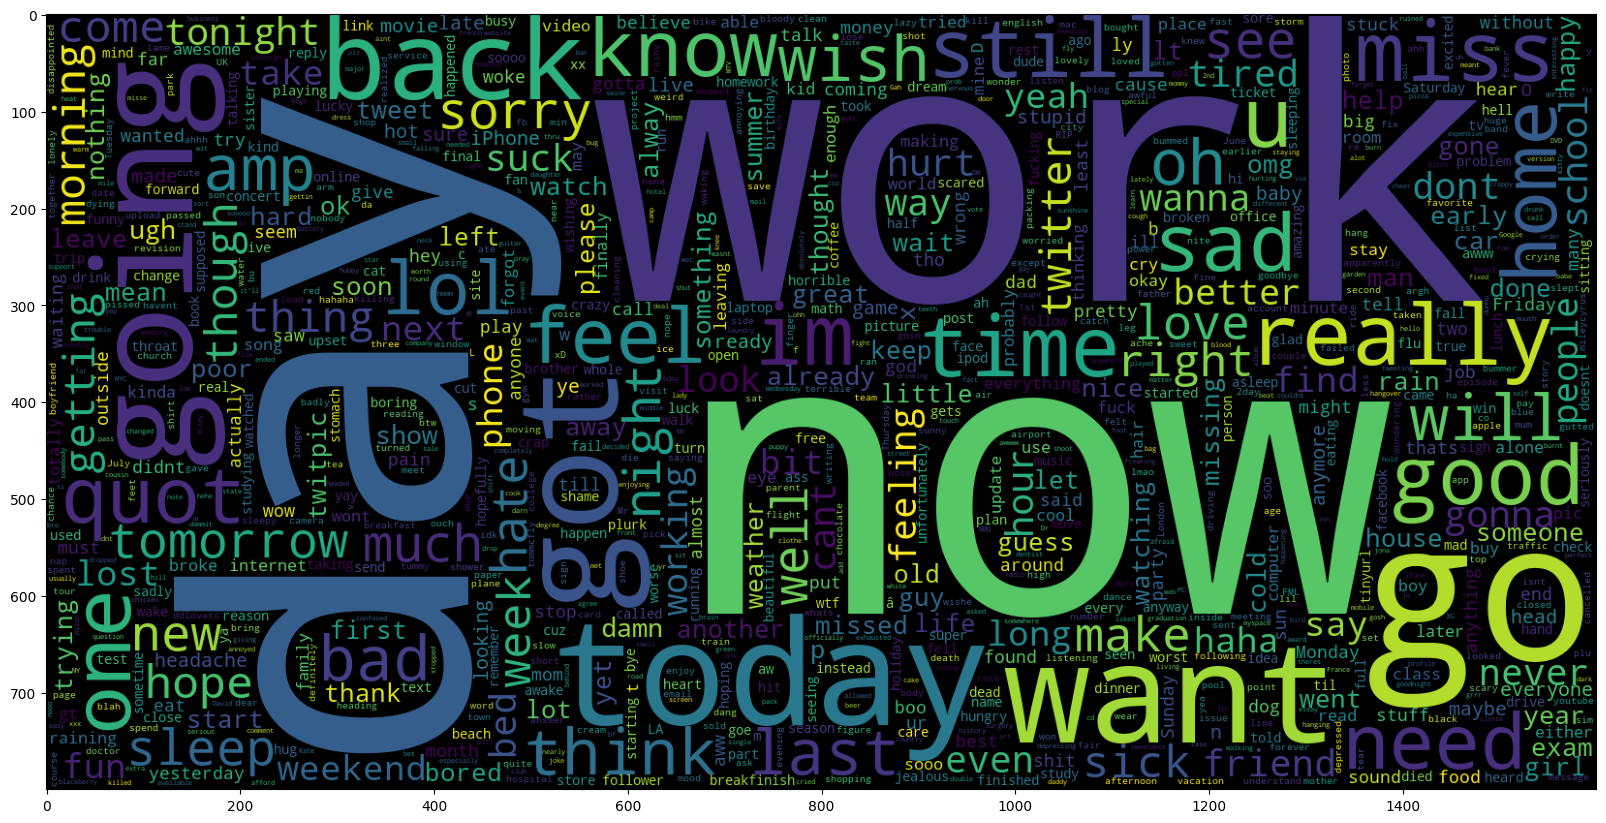

In [12]:
# Generate wordcloud with negative data points. 
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, collocations = False).generate(" ".join(data_neg))
plt.imshow(wc)
#plt.show()

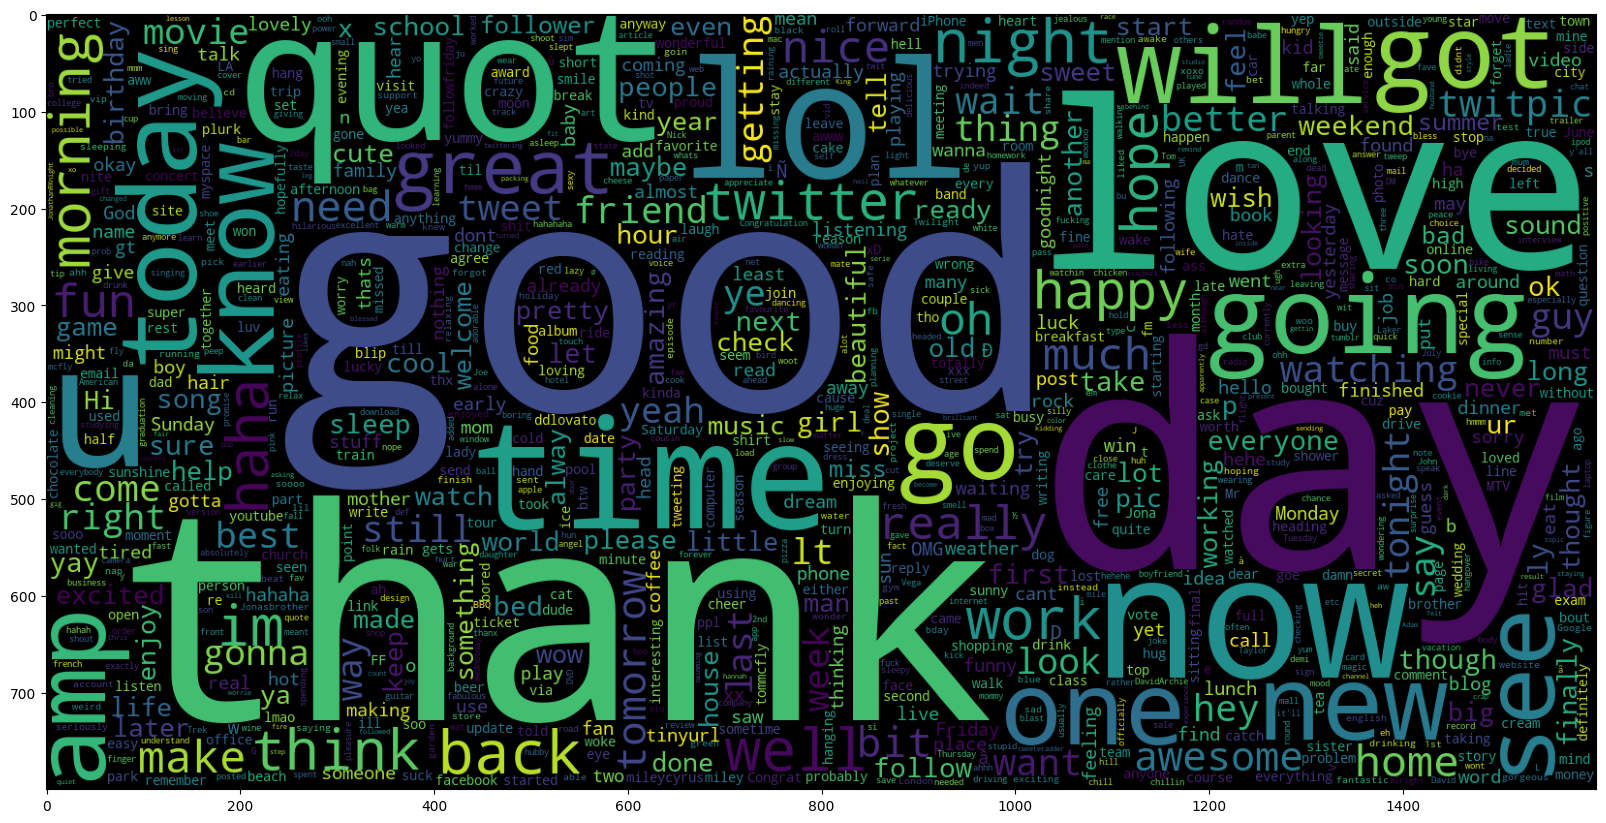

In [13]:
# Generate wordcloud with positive data points
data_pos = data['text'][800000:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, collocations = False).generate(" ".join(data_pos)) # Join is for the dataframe
plt.imshow(wc)

In [14]:
# Split the data using triain_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.05, random_state= 26105111)
print(X_train.head())

177690     @PanicCrew still no michigan shows    where's ...
270490     @rebekahnew I want to see your phone!!!!!! Sol...
272624     @akayoungin ohkohk, i just booked i put JUNE 3...
1378251    @austinhurst I hear it's amazing. Pulls no pun...
825497         Oh Ron White....  Time for bed now, methinks.
Name: text, dtype: object


In [15]:
# Transforming the dataset using TF-IDF vectorizer. 
# TF-IDF assigns importance on the each word based on TF and IDF. 
# There are another types of vectorizer such as 'Countvetorizer' - This function vectorize based on the frequency of the word. 
# Tfidf vectorizes using the Tf and Idf information. This can be simply put as importance of the word.
# Tf stands for term frequency, idf stands for inverse document frequency.
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1,2), max_features = 500000)
# There are many arguables for this function.
# ngram_range : type = tuple, if ngram is (1,2), two connected words such as 'very good' or 'go back' will get a single index.
# The default value of ngram is (1,1) which means that index will be assigned on the single word.
vectorizer.fit(X_train) # Note that the vectorizer function expects the input to be a text, not a list.
# using 'fit' command, the machine is going to study what kind of words are coming out from the data.
# Learning about the data = fit 
# Transforming the data = transform
print('Number of feature words', len(vectorizer.get_feature_names_out()))

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)


Number of feature words 500000


In [16]:
# Function of model evaluation. 
# There are three indicators for model performance. 
# 1) Accuracy score 2) confusion matrix 3) ROC-AUC curve 
def model_evaluate(model):
    # Predict the values for test dataset 
    Y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset. For the classification problem, accuracy will be an indicator.
    print(classification_report(Y_test,Y_pred))
    # Compute and plot the confusion matrix. 
    cf_matrix = confusion_matrix(Y_test,Y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Negative','False Positive','True Positive','False Positive']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues', fmt = '', xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values")
    plt.ylabel("Actual Values")
    plt.title("Confusion Matrix")
    plt.show()


              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



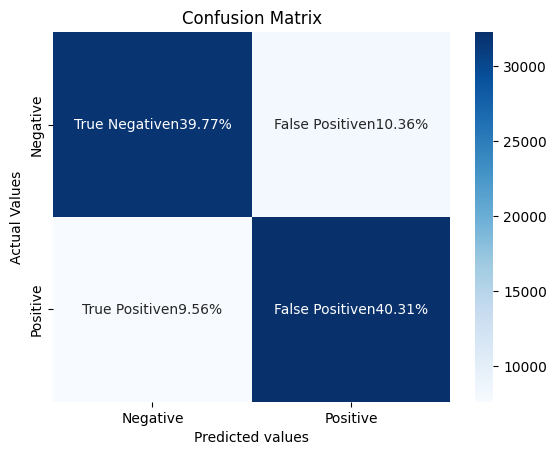

In [17]:
# Model Building
# 1) Bernoulli Naive Bayes Classifier 2) SVM 3) Logistic Regression 
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train,Y_train)
model_evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)